<a href="https://colab.research.google.com/github/parthkohli92/Tensorflow/blob/main/TransferLearning_ScalingUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow by Scaling Up

In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2021-10-29 07:42:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-29 07:42:42 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Downloading and preprocessing the data

In [2]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-10-29 07:42:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   116MB/s    in 14s     

2021-10-29 07:42:59 (114 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
# How many images are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 director

In [4]:
# Set up data inputs 
import tensorflow as tf 
IMG_SIZE=(224,224)

train_data_all_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Our data has 75 images per class in training set, and 25250 images in test set

## Train a model with transfer learning on 10% of 101 food classes

In [5]:
# Import req models 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.models import Sequential 

# Set up data augmentations
data_augmentations = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.3),
  preprocessing.RandomWidth(0.2) 
], name="data_augmentation")

In [6]:
# Set up the model 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Set up model architecture 
inputs = layers.Input(shape=(224,224,3), name="input_layer")

x = data_augmentations(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="gloabal_avg_pooling_2D")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax",name="output_layer")(x)

model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
gloabal_avg_pooling_2D (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


Our model has 5 layers but each of those layers have varying amounts of layers within them.

In [8]:
# Compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 576s 2s/step - loss: 3.4726 - accuracy: 0.2458 - val_loss: 2.7772 - val_accuracy: 0.3816
Epoch 2/5
237/237 [==============================] - 599s 3s/step - loss: 2.3662 - accuracy: 0.4543 - val_loss: 2.3317 - val_accuracy: 0.4404
Epoch 3/5
237/237 [==============================] - 586s 2s/step - loss: 2.0004 - accuracy: 0.5248 - val_loss: 2.1623 - val_accuracy: 0.4621
Epoch 4/5
237/237 [==============================] - 590s 2s/step - loss: 1.7866 - accuracy: 0.5710 - val_loss: 2.0898 - val_accuracy: 0.4664
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.6021

In [9]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 1192s 2s/step - loss: 1.7335 - accuracy: 0.5476


[1.7334871292114258, 0.547603964805603]

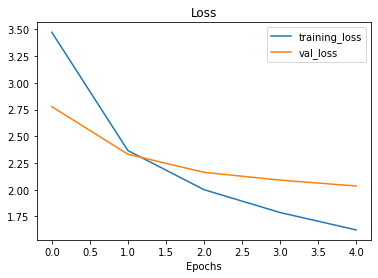

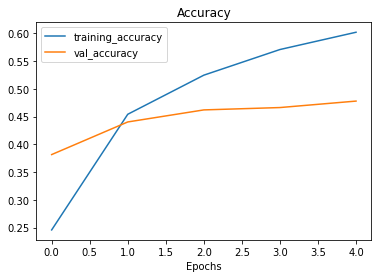

In [10]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning 

In [11]:
base_model.trainable = True

for layers in base_model.layers[:-5]:
  layers.trainable = False

In [12]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [13]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
gloabal_avg_pooling_2D True
output_layer True


In [14]:
# which layers are trainable?
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 614s 3s/step - loss: 1.3819 - accuracy: 0.6438 - val_loss: 1.9522 - val_accuracy: 0.4976
Epoch 6/10
237/237 [==============================] - 641s 3s/step - loss: 1.2729 - accuracy: 0.6638 - val_loss: 1.9554 - val_accuracy: 0.5048
Epoch 7/10
237/237 [==============================] - 662s 3s/step - loss: 1.1839 - accuracy: 0.6931 - val_loss: 1.9373 - val_accuracy: 0.5090
Epoch 8/10
237/237 [==============================] - 677s 3s/step - loss: 1.1015 - accuracy: 0.7137 - val_loss: 1.9329 - val_accuracy: 0.5164
Epoch 9/10
 83/237 [=========>....................] - ETA: 5:03 - loss: 1.0619 - accuracy: 0.7044

In [ ]:
# Evaluate fine tuning the whole model on the test dataset 
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune 

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Evaluating the perfomance of the model across all the diff classes

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy